<a href="https://colab.research.google.com/github/lorenzkuhn/advi/blob/main/GaussianMixtureModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Mixture Model with Pyro


In [ ]:
!pip3 install pyro-ppl 

In [ ]:
import numpy as np

import random

import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro.contrib.autoguide import AutoDelta

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

### USAGE

K is the number of Gaussian components

D is the data dimensionality

LOCS and SCALES are the corresponding tensors storing the means and covariances

Set the below constants to generate a mixture of arbitrary Gaussians. For simplicity the model takes the weight of all gaussians equal, and again for simplicity I have used a Bimodal distribution in this example. We can go for more complicated ones by simply setting K, D, LOCS and SCALES but last year's group also did bimodal, I think it's enough to demonstrate.

In [ ]:
K = 2 # number of Gaussian components

D = 2 # data dimensionality 

LOCS = torch.tensor([[2, 2], [4, 4]], dtype=torch.float)

SCALES = torch.tensor([[[.5, .25],
                        [.25, 1.]],
                       [[.5, -.25],
                        [-.25, 1.]]], dtype=torch.float)

In [ ]:
class GaussianMixtureModel:

    def __init__(self, k, d, locs, scales):
        self.k = k
        self.d = d
            
        assert locs.size() == (k, d), 'Input locs must be a tensor of size (%i, %i)' % (k, d)
        self.locs = locs
            
        assert scales.size() == (k, d, d), 'GMM: scales must be a tensor of size (%i, %i, %i)' % (k, d, d)
        self.scales = scales
            
        self.init_gaussians()

    def init_gaussians(self):
        self.gaussians = [dist.MultivariateNormal(self.locs[i], self.scales[i]) for i in range(self.k)]

    def log_likelihood(self, data, params):
        total_log_prob = 0
        for gaussian in self.gaussians:
            total_log_prob += gaussian.log_prob(params)
        return total_log_prob / self.k

    def sample(self, n):
        m = n // self.k
        m_last = m + n % self.k
        shuffled_gaussians = random.sample(self.gaussians, self.k)
        samples = torch.stack([pyro.sample('samples1', shuffled_gaussians[0]) for _ in range((m if m != 0 else m_last))])
        for i in range(1, self.k - 1):
            new_samples = torch.stack([pyro.sample('samples' + str(i + 1), shuffled_gaussians[i]) for _ in range(m)])
            samples = torch.cat((samples, new_samples))
        last_samples = torch.stack([pyro.sample('samples' + str(self.k), shuffled_gaussians[-1]) for _ in range(m_last)])
        samples = torch.cat((samples, last_samples))
        samples = samples[torch.randperm(n)] # shuffle samples
        return samples 

In [ ]:
BIMODAL = GaussianMixtureModel(K, D, LOCS, SCALES)

In [ ]:
N = 1000

assert N > K, 'Dataset size N locst be greater'

DATA = BIMODAL.sample(N)

## Pyro Counterpart of the Bimodal Distribution defined above



We will use Pyro to infer the parameters of the Bimodal Gaussian Mixture Model we have defined above. Thus, we initialize a Pyro model representing the same distribution.


In [ ]:
torch.manual_seed(7)
random.seed(7)

RANDOM_LOCS = torch.rand(D)
TEMP = torch.rand(D, D)
RANDOM_SCALES = TEMP @ TEMP.T
for _ in range(K - 1):
    TEMP = torch.rand(D, D)
    RANDOM_SCALES = torch.stack((RANDOM_SCALES, TEMP @ TEMP.T))
    RANDOM_LOCS = torch.stack((RANDOM_LOCS, torch.rand(D)))
RANDOM_SCALES, RANDOM_LOCS

(tensor([[[0.8661, 0.4327],
          [0.4327, 0.2349]],
 
         [[0.4395, 0.6117],
          [0.6117, 0.8581]]]), tensor([[0.5349, 0.1988],
         [0.8549, 0.5509]]))

In [ ]:
@config_enumerate(default='parallel')
@poutine.broadcast
def model(data):

    # Global variables
    weights = pyro.param('weights', torch.FloatTensor([1 / K]), constraint=constraints.unit_interval)
    locs = pyro.param('locs', RANDOM_LOCS)
    scales = pyro.param('scales', RANDOM_SCALES)

    with pyro.iarange('data', data.size(0)):
        # Local variables
        assignment = pyro.sample('assignment', dist.Bernoulli(torch.ones(len(data)) * weights)).to(torch.int64)
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)

In [ ]:
@config_enumerate(default='parallel')
@poutine.broadcast
def full_guide(data):
    with pyro.iarange('data', data.size(0)):
        # Local variables
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K, constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs), infer={'enumerate': 'sequential'})

In [ ]:
def initialize(data):
    pyro.clear_param_store()

    optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_iarange_nesting=1)
    svi = SVI(model, full_guide, optim, loss=elbo)

    # Initialize weights to uniform
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)

    # Assume half of the data variance is due to intra-component noise
    var = (data.var() / 2).sqrt()
    pyro.param('auto_scale', torch.tensor([var] * 4), constraint=constraints.positive)

    # Initialize means from a subsample of data
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])

    loss = svi.loss(model, full_guide, data)

    return loss, svi

In [ ]:
def plot(data, locs=None, scales=None, colors='black', figname='fig.png'):
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=colors)

    # Plot cluster centers
    if locs is not None:
        x = [float(m[0]) for m in locs]
        y = [float(m[1]) for m in locs]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if scales is not None:
        for k in range(K):
            ax = fig.gca()
            cov = np.array(scales[k])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[k], y[k]),
                          width=lam[0] * 4, height=lam[1] * 4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

    # Save figure
    #fig.savefig(figname)

[iteration 1]	 loss: 138.8975
[iteration 2]	 loss: 12.3319
[iteration 3]	 loss: 10.6985
[iteration 4]	 loss: 10.1296
[iteration 5]	 loss: 9.8290
[iteration 6]	 loss: 9.6321
[iteration 7]	 loss: 9.4852
[iteration 8]	 loss: 9.3653
[iteration 9]	 loss: 9.2607
[iteration 10]	 loss: 9.1654
[iteration 11]	 loss: 9.0761
[iteration 12]	 loss: 8.9906
[iteration 13]	 loss: 8.9075
[iteration 14]	 loss: 8.8261
[iteration 15]	 loss: 8.7459
[iteration 16]	 loss: 8.6663
[iteration 17]	 loss: 8.5873
[iteration 18]	 loss: 8.5087
[iteration 19]	 loss: 8.4304
[iteration 20]	 loss: 8.3524
[iteration 21]	 loss: 8.2746
[iteration 22]	 loss: 8.1970
[iteration 23]	 loss: 8.1197
[iteration 24]	 loss: 8.0426
[iteration 25]	 loss: 7.9658
[iteration 26]	 loss: 7.8892
[iteration 27]	 loss: 7.8130
[iteration 28]	 loss: 7.7371
[iteration 29]	 loss: 7.6615
[iteration 30]	 loss: 7.5863
[iteration 31]	 loss: 7.5116
[iteration 32]	 loss: 7.4372
[iteration 33]	 loss: 7.3633
[iteration 34]	 loss: 7.2899
[iteration 35]	 lo

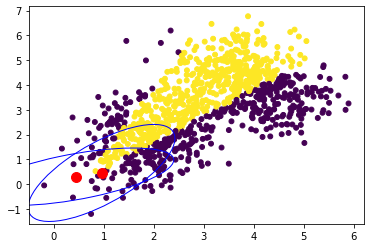

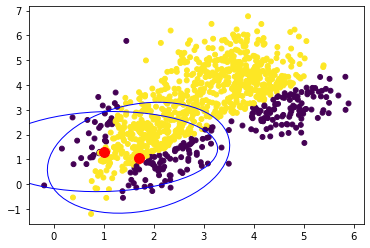

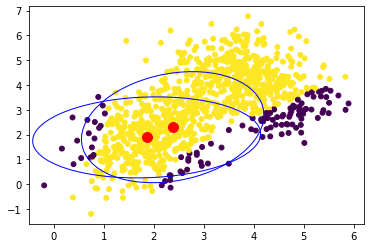

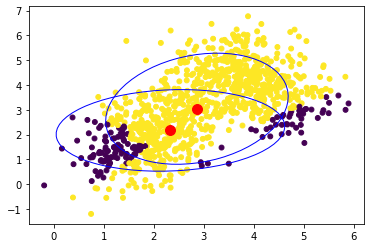

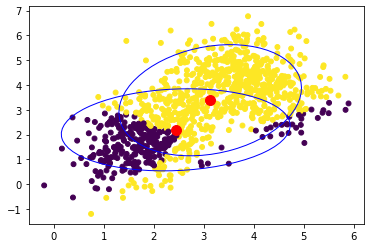

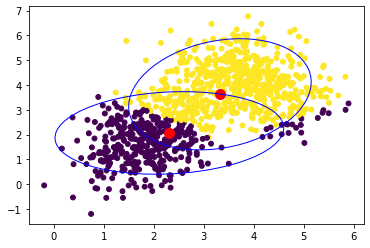

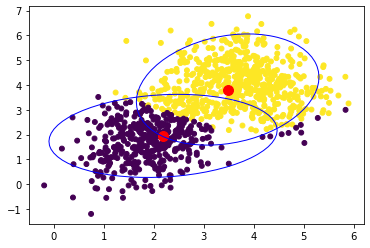

In [ ]:
pyro.enable_validation(True)
pyro.set_rng_seed(101)

global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scales']))
global_guide = config_enumerate(global_guide, 'parallel')
_, svi = initialize(DATA)

for i in range(301):
    loss = svi.step(DATA)
    print('[iteration %i]\t loss: %.4f' % (i + 1, loss / N))

    if i % 50 == 0:

        locs = pyro.param('locs')
        scales = pyro.param('scales')
        weights = pyro.param('weights')
        assignment_probs = pyro.param('assignment_probs')

        # Plot data and estimates
        assignments = np.uint8(np.round(assignment_probs.data))
        plot(DATA.detach().numpy(), locs.data, scales.data, assignments, figname='pyro_iteration{}.png'.format(i))